In [52]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
def load_combined_dataset(json_path):
    """
    Reads the combined dataset JSON and returns it as a Python list of dicts.
    Each item has: { "tokens": [...], "ner_tags": [...], "intent": "..." }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [32]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define Neural Network Model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.fc(cls_output)


In [33]:
# Load Data
json_path = "train_test_split/train_combined.json"
data = load_combined_dataset(json_path)
texts = [" ".join(item["tokens"]) for item in data]
labels = [item["intent"] for item in data]
label_to_id = {label: idx for idx, label in enumerate(set(labels))}
labels = [label_to_id[label] for label in labels]

In [34]:
# Split Data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenizer and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize Model
num_classes = len(label_to_id)
model = BERTClassifier('bert-base-uncased', num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [35]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.7213555234203856
Epoch 2, Loss: 0.18296819224011107
Epoch 3, Loss: 0.09831219133229022


In [41]:
# Validation Loop
model.eval()
val_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}")



Validation Loss: 0.10837200905994646, Accuracy: 0.9779116465863453


In [43]:
# Ensure label alignment for classification report and confusion matrix
unique_labels = sorted(set(all_labels))
id_to_label = {v: k for k, v in label_to_id.items()}
target_names = [id_to_label[label] for label in unique_labels]

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=target_names))

macro_f1 = f1_score(all_labels, all_predictions, average="macro")
print(f"Overall Macro F1 Score: {macro_f1:.3f}")


Classification Report:
                           precision    recall  f1-score   support

                 quantity       1.00      0.80      0.89        10
                   flight       0.99      0.99      0.99       752
           ground_service       0.98      1.00      0.99        42
              restriction       0.00      0.00      0.00         2
                  airline       1.00      0.97      0.99        37
             abbreviation       0.89      0.85      0.87        20
              flight_time       0.70      0.88      0.78         8
           flight+airfare       1.00      1.00      1.00         5
              ground_fare       1.00      1.00      1.00         1
                 capacity       0.67      1.00      0.80         2
                flight_no       1.00      0.25      0.40         4
                 aircraft       0.94      1.00      0.97        15
                  airport       0.43      1.00      0.60         3
                 distance       1.00 

c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

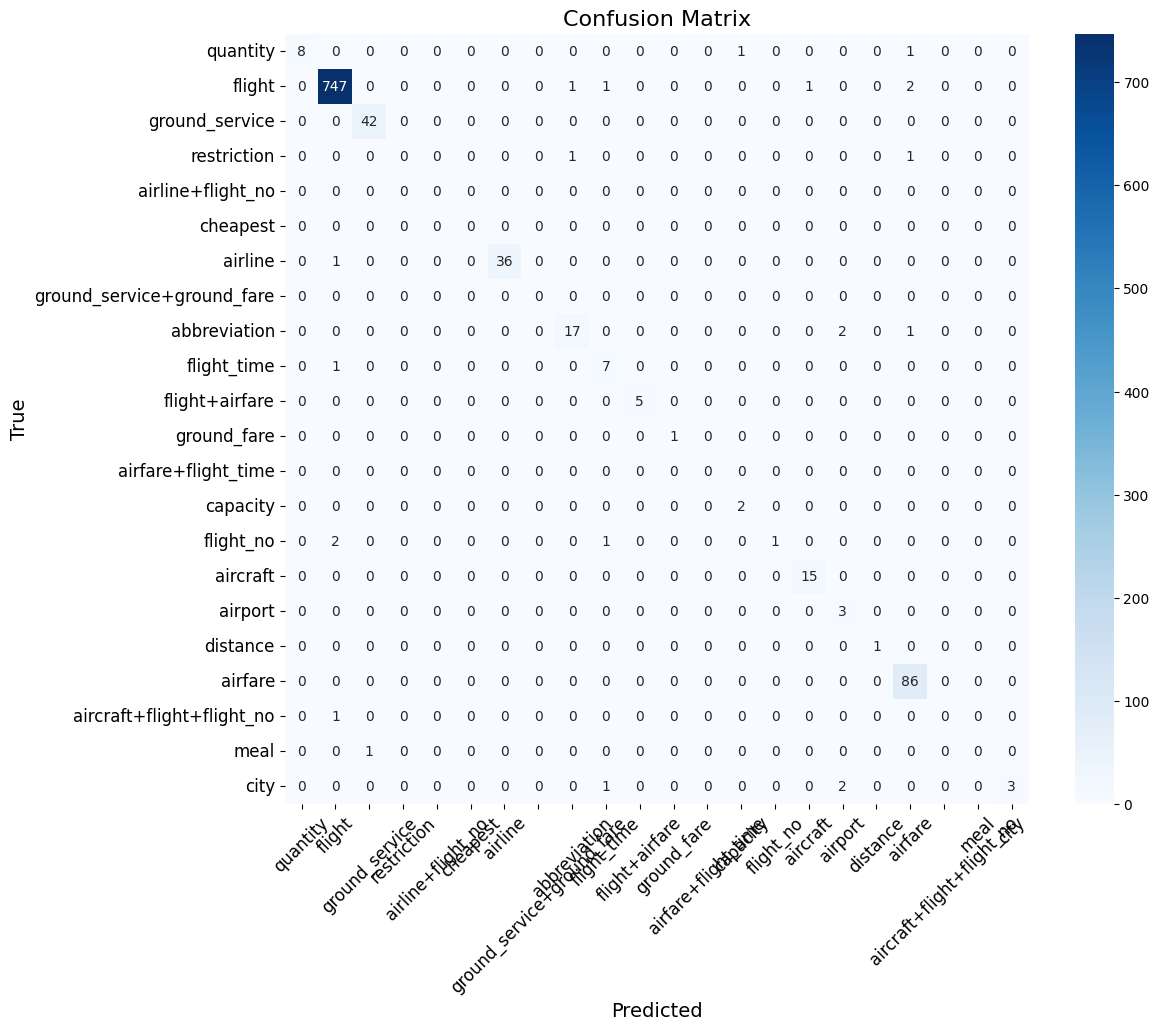

In [53]:
# Convert label_to_id keys to a sorted list of class names
id_to_label = {v: k for k, v in label_to_id.items()}
sorted_classes = [id_to_label[i] for i in sorted(id_to_label.keys())]

# Confusion Matrix with Heatmap
cm = confusion_matrix(all_labels, all_predictions, labels=list(id_to_label.keys()))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()
